In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math



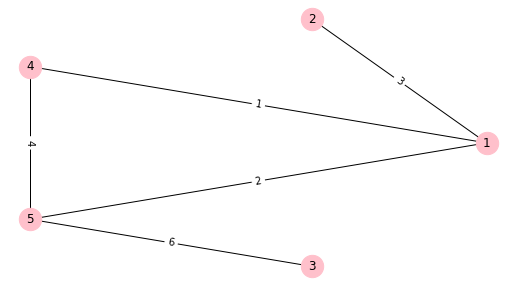

In [38]:
graph = nx.Graph()

graph.add_edge(1, 2, weight=3)
graph.add_edge(1, 4, weight=1)
graph.add_edge(1, 5, weight=2)
graph.add_edge(4, 5, weight=4)
graph.add_edge(5, 3, weight=6)


options = {
    'node_color': 'pink',
    'node_size': 500,
    'width': 1,
}

plt.figure(figsize=(9,5))

npos=nx.circular_layout(graph,scale=1)
labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos = npos,edge_labels=labels)

nx.draw(graph,pos = npos, **options, with_labels=True)
plt.show()

In [39]:
A = nx.to_numpy_matrix(graph)


In [40]:
n = 5
P = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        
        P[i,j] = A[i,j]/np.sum(A[i,:])
        
print(P)


[[0.         0.5        0.16666667 0.33333333 0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.2        0.         0.         0.8        0.        ]
 [0.16666667 0.         0.33333333 0.         0.5       ]
 [0.         0.         0.         1.         0.        ]]


In [41]:
def check_sum_lines(n, P):
        
    for i in range(n):
        for j in range(n):

            if(not math.isclose(np.sum(P[i,:]),1)):
                print('A matriz não é estocástica')
                return False
    print('A matriz é estocástica')
    return True
    

In [42]:
check_sum_lines(n, P)

A matriz é estocástica


True